In [4]:
import warnings
warnings.filterwarnings("ignore")

## Paper2_functions

In [5]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data

def Adata2Torch_data(adata): 
    G_df = adata.uns['Spatial_Net'].copy() 
    spots = np.array(adata.obs_names) 
    spots_id_tran = dict(zip(spots, range(spots.shape[0]))) 
    G_df['Spot1'] = G_df['Spot1'].map(spots_id_tran) 
    G_df['Spot2'] = G_df['Spot2'].map(spots_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Spot1'], G_df['Spot2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G) 
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))  # .todense()
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))  # .todense()
    return data

def Spatial_Dis_Cal(adata, rad_dis=None, knn_dis=None, model='Radius', verbose=True):
    """\
    Calculate the spatial neighbor networks, as the distance between two spots.
    Parameters
    ----------
    adata:  AnnData object of scanpy package.
    rad_dis:  radius distance when model='Radius' 半径
    knn_dis:  The number of nearest neighbors when model='KNN' 邻居个数
    model:
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_dis. 
        When model=='KNN', the spot is connected to its first knn_dis nearest neighbors.
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """
    assert(model in ['Radius', 'KNN']) 
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial']) 
    coor.index = adata.obs.index 
    # coor.columns = ['imagerow', 'imagecol']
    coor.columns = ['Spatial_X', 'Spatial_Y'] 

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_dis).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        # Find the neighbors within a given radius of a point or points.
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot]*indices[spot].shape[0], indices[spot], distances[spot]))) #每个spot的邻居编号；距离。
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=knn_dis+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot]*indices.shape[1],indices[spot,:], distances[spot,:])))

    KNN_df = pd.concat(KNN_list) 
    KNN_df.columns = ['Spot1', 'Spot2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_spot_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), )) 
    Spatial_Net['Spot1'] = Spatial_Net['Spot1'].map(id_spot_trans) 
    Spatial_Net['Spot2'] = Spatial_Net['Spot2'].map(id_spot_trans) 
    if verbose:
        print('The graph contains %d edges, %d spots.' %(Spatial_Net.shape[0], adata.n_obs)) 
        print('%.4f neighbors per spot on average.' %(Spatial_Net.shape[0]/adata.n_obs)) 

    adata.uns['Spatial_Net'] = Spatial_Net

def Spatial_Dis_Draw(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Spot1'].shape[0] 
    Mean_edge = Num_edge/adata.shape[0] 
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Spot1'])) 
    plot_df = plot_df/adata.shape[0]  
    fig, ax = plt.subplots(figsize=[4,4],dpi=300)
    plt.ylabel('Percentage')
    plt.xlabel('Edge Numbers per Spot')
    plt.title('Number of Neighbors for Spots (Average=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df,color="#aa40fc",edgecolor="#f7b6d2",linewidth=2)

def Cal_Spatial_variable_genes(adata):
    import SpatialDE
    # counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
    counts = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    coor = pd.DataFrame(adata.obsm['spatial'], columns=['Spatial_X', 'Spatial_Y'], index=adata.obs_names)
    Spatial_var_genes = SpatialDE.run(coor, counts)
    Spatial_3000_var_genes = Spatial_var_genes["g"].values[0:3000]
    Spatial_3000_var_genes = pd.DataFrame(Spatial_3000_var_genes)
    all_genes = counts.columns.to_frame()
    for i in range(len(all_genes.values)):
        if all_genes.values[i] in Spatial_3000_var_genes.values:
            all_genes.values[i] =1
        else:
            all_genes.values[i] =0
    Spatial_highly_genes = all_genes.squeeze()
    adata.var["Spatial_highly_variable_genes"] = Spatial_highly_genes.astype(bool)

def DGI_loss_Draw(adata):
    import matplotlib.pyplot as plt
    if "Model_loss" not in adata.uns.keys():
        raise ValueError("Please Train Graph Deep Learning Model first!") 
    Train_loss = adata.uns["Model_loss"]
    plt.style.use('default') #'seaborn-poster';seaborn-paper';'seaborn-deep''ggplot'
    plt.plot(Train_loss,label='Training loss',linewidth=2)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss of pyG model")
    plt.legend()
    plt.grid()

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


In [6]:
import scanpy as sc
adata=sc.read('/home/tengliu/Torch_pyG-Paper1/DLPFC_Comparison/SPGDL/Anndata/151676_Anndata.h5ad')

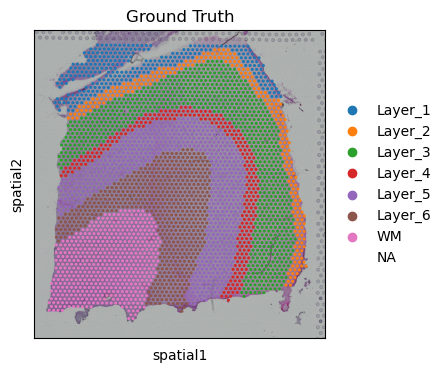

In [7]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [8]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'spatial', 'Ground Truth_colors'
    obsm: 'spatial'

In [ ]:
Spatial_Dis_Cal(adata,rad_dis=150)
Spatial_Dis_Draw(adata)

## Training process using 20 GNNs

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
import scipy.sparse as sp 

from Paper2_DGI_Models import ARMAmodel,Chebmodel,ClusterGCNmodel,EGmodel,FeaStmodel,FiLMmodel,GATv2model,\
GENmodel,Generalmodel,Graphmodel,Hypergraphmodel,LEmodel,MFmodel,ResGatedGraphmodel,\
SAGEmodel,SGmodel,SuperGATmodel,TAGmodel,Transformermodel,GCNmodel

import torch
import torch.backends.cudnn as cudnn
cudnn.deterministic = True #
cudnn.benchmark = True 
import torch.nn.functional as F 
from torch_geometric.nn import DeepGraphInfomax, global_mean_pool, global_max_pool  # noqa 

from Paper2_functions import Adata2Torch_data

module_list = [ARMAmodel,Chebmodel,ClusterGCNmodel,EGmodel,FeaStmodel,FiLMmodel,GATv2model,GENmodel,Generalmodel,Graphmodel,\
Hypergraphmodel,LEmodel,MFmodel,ResGatedGraphmodel,SAGEmodel,SGmodel,SuperGATmodel,TAGmodel,Transformermodel,GCNmodel]

# module_list = [ResGatedGraphmodel,SAGEmodel,SGmodel]

adata_list = [_ for _ in range(len(module_list))]
adata_new = adata.copy() #backup the original anndata

for num_module in tqdm(range(0, len(module_list))):
    adata = adata_new.copy() #load the original anndata
    
    class my_data():
        def __init__(self, x, edge_index, edge_attr):
            self.x = x
            self.edge_index = edge_index
            self.edge_attr = edge_attr

    def corruption(data): 
        x = data.x[torch.randperm(data.x.size(0))] 
        return my_data(x, data.edge_index, data.edge_attr)
    # data.x: feature matrix ([num_nodes, num_node_features]); data.edge_index:Graph connectivity ([2, num_edges]);
    # data.edge_attr: Edge feature matrix ([num_edges, num_edge_features])



    def DGI_Train(adata, 
                    hidden_dims=[128, 128], 
                    num_epochs=5000, 
                    lr=1e-6, 
                    key_added='SCGDL',
                    gradient_clipping=5., 
                    weight_decay=0.0001, 
                    random_seed=0, save_loss=True):
        """\
        Training graph attention auto-encoder.
        Parameters
        ----------
        adata: AnnData object of scanpy package.
        hidden_dims: The dimension of the encoder.
        n_epochs:Number of total epochs for training.
        lr: Learning rate for AdamOptimizer.
        key_added: The latent embeddings are saved in adata.obsm[key_added].
        gradient_clipping: Gradient Clipping.
        weight_decay: Weight decay for AdamOptimizer.
        save_loss: If True, the training loss is saved in adata.uns['SCGDL_loss'].
        save_reconst_exp: If True, the reconstructed expression profiles are saved in adata.layers['SCGDL_ReX'].
        device: See torch.device.

        Returns
        -------
        AnnData
        """
        # seed_everything() 
        seed=random_seed
        import random
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)

        adata.X = sp.csr_matrix(adata.X)

        if "Spatial_highly_variable_genes" in adata.var.columns:
            adata_Vars =  adata[:, adata.var['Spatial_highly_variable_genes']]
            print('Input Size using Spatial_variable_genes: ', adata_Vars.shape)
        elif 'highly_variable' in adata.var.columns:
            adata_Vars =  adata[:, adata.var['highly_variable']]
            print('Input Size using Highly_variable_genes: ', adata_Vars.shape)
        else:
            adata_Vars = adata
            print('Input Size using All genes list: ', adata_Vars.shape) 

        if 'Spatial_Net' not in adata.uns.keys():
            raise ValueError("Please Compute Spatial Network using Spatial_Dis_Cal function first!") 

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        data = Adata2Torch_data(adata_Vars) #create torch.pyG data
        hidden_dims = [data.x.shape[1]] + hidden_dims 

        # Setting Deep Graph Infomax (DGI) model
        DGI_model = DeepGraphInfomax(
            hidden_channels=hidden_dims[1], #The latent space dimensionality
            encoder=module_list[num_module](hidden_dims), #encoder module
            summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)), 
            corruption=corruption).to(device) #The corruption function
        DGI_optimizer = torch.optim.Adam(DGI_model.parameters(), lr=lr, weight_decay=weight_decay)
        data = data.to(device)

        # Training Deep Graph Infomax (DGI) model using GAT
        import time
        start_time = time.time()
        loss_list = []
        for epoch in tqdm(range(1, num_epochs+1)):
            DGI_model.train()
            DGI_optimizer.zero_grad() 
            pos_z, neg_z, summary = DGI_model(data=data) 
            DGI_loss = DGI_model.loss(pos_z, neg_z, summary) 
            loss_list.append(float(DGI_loss.item()))
            DGI_loss.backward()
            torch.nn.utils.clip_grad_norm_(DGI_model.parameters(), gradient_clipping) 
            DGI_optimizer.step()
            if ((epoch)%1000) == 0:
                print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, np.mean(loss_list)))
        end_time = time.time()
        print('Elapsed training time:{:.4f} seconds'.format((end_time-start_time)))

        #Evaluating Deep Graph Infomax (DGI) model
        DGI_model.eval()
        # z, out = DGI_model(data.x, data.edge_index) 
        pos_z, neg_z, summary = DGI_model(data=data) 

        SCGDL_rep = pos_z.to('cpu').detach().numpy() 
        adata.obsm[key_added] = SCGDL_rep
        adata.uns["Time"] = end_time-start_time

        if save_loss:
            adata.uns['Model_loss'] = loss_list 

        return adata
    
    adata = DGI_Train(adata)
    sc.pp.neighbors(adata, use_rep='SCGDL')
    sc.tl.umap(adata)
    ## Spatial clustering using latent representations in the embedding space    
    from sklearn.cluster import KMeans
    from sklearn.metrics.cluster import adjusted_rand_score
    num_cluster = 5 
    kmeans = KMeans(n_clusters=num_cluster, algorithm = "lloyd", random_state=0).fit(adata.obsm['SCGDL'])
    ## Load KMeans lables in adata.obs
    adata.obs["KMeans"] = adata.obs["Ground Truth"]   
    adata.obs["KMeans"] = kmeans.labels_    
    obs_df = adata.obs.dropna() 
    ARI = adjusted_rand_score(obs_df["KMeans"], obs_df['Ground Truth']) 
    print('Adjusted rand index = %.2f' %ARI)    
    adata.uns["ARI"] = ARI
    adata_list[num_module] = adata
import pickle
file = open("./Results/151669_DGI.pickle","wb")
pickle.dump(adata_list,file)
file.close()